In [18]:
import pandas as pd

df = pd.read_csv("Data/AAPL1.csv")

print(df.head())

# ## We will use only the closing price

         Date      Open      High       Low     Close  Adj Close     Volume
0  1980-12-12  0.513393  0.515625  0.513393  0.513393   0.023186  117258400
1  1980-12-15  0.488839  0.488839  0.486607  0.486607   0.021977   43971200
2  1980-12-16  0.453125  0.453125  0.450893  0.450893   0.020364   26432000
3  1980-12-17  0.462054  0.464286  0.462054  0.462054   0.020868   21610400
4  1980-12-18  0.475446  0.477679  0.475446  0.475446   0.021473   18362400


In [19]:

closePrice = df['Close']

print(closePrice.head())

0    0.513393
1    0.486607
2    0.450893
3    0.462054
4    0.475446
Name: Close, dtype: float64


In [20]:
from keras.layers.core import Dense, Activation, Dropout
# LSTM will help us to work with time events
from keras.layers.recurrent import LSTM
from keras.models import Sequential

In [21]:

import numpy as np
import matplotlib.pyplot as plt

def load_data(data, seq_len=50, normalise_window=True):
    data = list(data)
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    
    if normalise_window:
        result = normalise_windows(result)

    result = np.array(result)

    train_ratio = 0.9
    
    row = round(train_ratio * result.shape[0])
    train = result[:int(row), :]
    np.random.shuffle(train)
    x_train = train[:, :-1]
    y_train = train[:, -1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  

    return [x_train, y_train, x_test, y_test]


In [22]:

def normalise_windows(window_data):
    normalised_data = []
    for window in window_data:
        normalised_window = []
        normalised_window = [(float(p) / float(window[0]) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data

def predict_sequences_multiple(model, data, window_size, prediction_len):
    #Predict sequence of 50 steps before shifting prediction run forward by 50 steps
    prediction_seqs = []
    for i in range(int(len(data)//prediction_len)):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[np.newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white',figsize=(30,20))
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    #Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., prop={'size': 40})
    plt.show()


In [23]:
# # Split our dataset

x_train, y_train, x_test, y_test = load_data(closePrice,seq_len=50, normalise_window=True)

In [24]:
# Build Model

In [25]:
#initialize liner model of layers
model = Sequential()
# add LONG SHORT TERM MEMORY layer
# input dimension is 1
# output dimension is how many units of lstm do we want
# return_sequences means that the output of the layer is ALWAYS fed to the next layer
model.add(LSTM(
                input_dim=1,
                output_dim=50,
                return_sequences=True))



/Users/yaron/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  # Remove the CWD from sys.path while we load stuff.
/Users/yaron/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(None, 1), units=50)`
  # Remove the CWD from sys.path while we load stuff.


In [26]:


#add dropout layer of 20%
model.add(Dropout(0.2))

#add another lstm layer
#we will use 100 units
#return_sequences is false because we want the output to be fed only at the end of the sequence
#will give as a prediction vector
model.add(LSTM(
                
                output_dim=100,
                return_sequences=False))

#add dropout layer of 20%
model.add(Dropout(0.2))

#add dense layer (=fully connected layer) to aggregate it to a single neuron
model.add(Dense(
                output_dim=1))

#pass it through activation function
model.add(Activation('linear'))

#compile the model with error messurment of mse (mean squared error)
#and an optimiser of rmsprop(gradient descent)
model.compile(loss='mse', optimizer='rmsprop')

/Users/yaron/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=False, units=100)`
  del sys.path[0]
/Users/yaron/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


In [27]:

# # Train our model


model.fit(x_train,
          y_train,
          batch_size=512,
          #epochs=30,
          epochs=3,
          validation_split=0.05)

Train on 5792 samples, validate on 305 samples
Epoch 1/3
5792/5792 [==============================] - 40s 7ms/step - loss: 0.0170 - val_loss: 0.0058
Epoch 2/3
5792/5792 [==============================] - 41s 7ms/step - loss: 0.0067 - val_loss: 0.0071
Epoch 3/3
5792/5792 [==============================] - 42s 7ms/step - loss: 0.0056 - val_loss: 0.0084


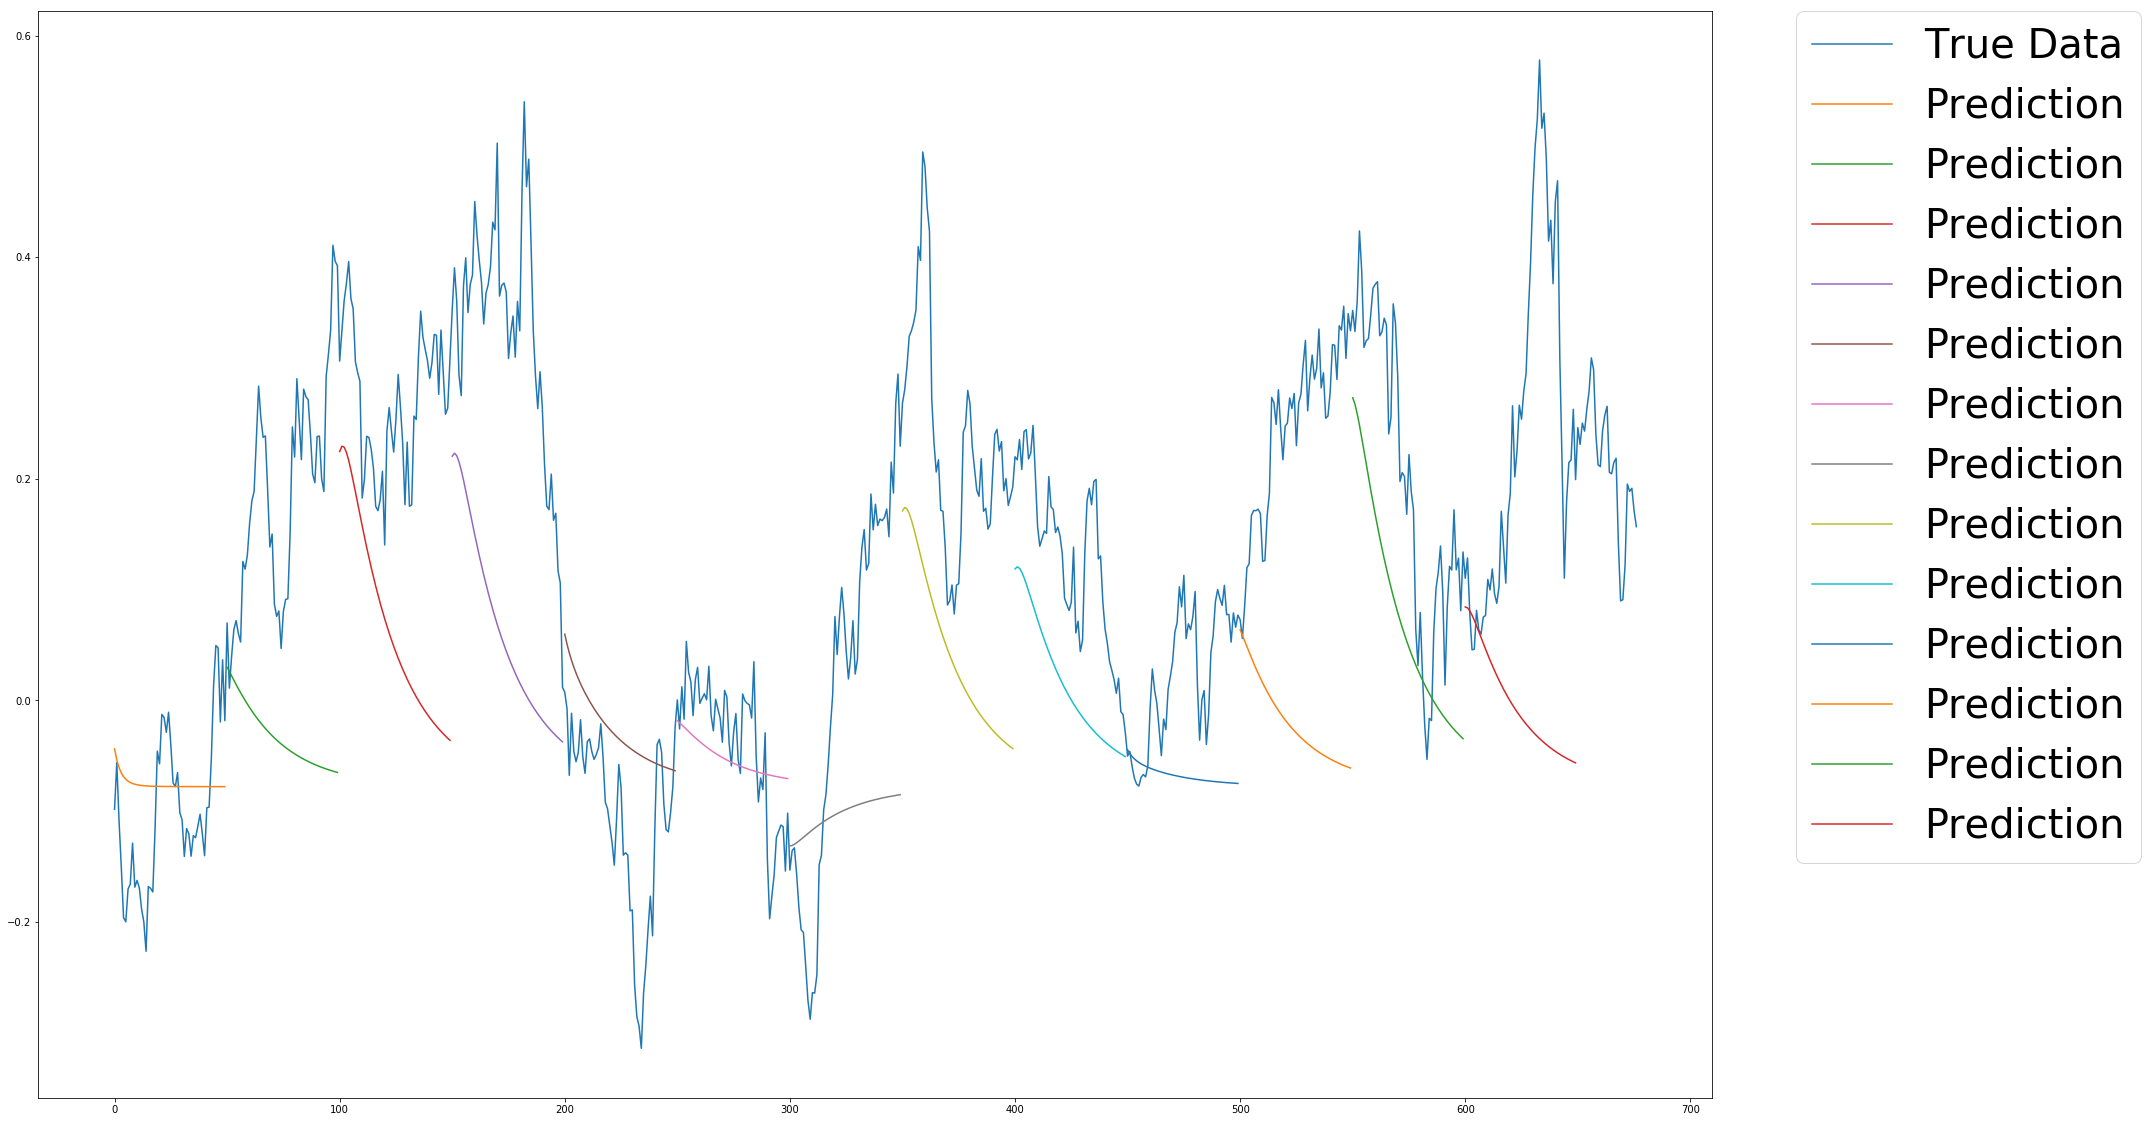

In [28]:
# # Predict!

predictions = predict_sequences_multiple(model, x_test, 50, 50)
#plot it
plot_results_multiple(predictions, y_test, 50)
